# Secrets behind recipes

Team member: Tianyang Dong, Wei Jiang, Huajian Qiu, Jiahua Wu

---
## 0 Import libraries and recipe dataset

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import inflect
import os

In [76]:
recipe = pd.read_csv('data/RAW_recipes.csv')

In [77]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
name              231636 non-null object
id                231637 non-null int64
minutes           231637 non-null int64
contributor_id    231637 non-null int64
submitted         231637 non-null object
tags              231637 non-null object
nutrition         231637 non-null object
n_steps           231637 non-null int64
steps             231637 non-null object
description       226658 non-null object
ingredients       231637 non-null object
n_ingredients     231637 non-null int64
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [78]:
# Split the nutrition list
nutritions_list = ["calories(kJ)", "total_fat(g)", "sugar(g)", "sodium(mg)", "protein(g)", "sat_fat(g)", "carbs(g)"]
recipe['nutrition'] = recipe['nutrition'].apply(eval)
recipe[nutritions_list] = pd.DataFrame(recipe.nutrition.values.tolist(), index=recipe.index)
recipe = recipe.drop(['nutrition'], axis=1)

---

# 1 Data cleaning of recipes

## 1.1 Map recipe to countries (regions) and continents

First, drop the rows that have nan values on column 'name'. Since 'description' is irrelavent to our analysis, we will not deal with the missing values in column 'description'.

The information about country/region is extracted from the tags, for example, there are tags like 'american', 'southern-united-states', 'scottish'. These tags will be mapped to countries if they describes a part of a country, e.g. 'southern-united-states' to 'America', otherwise they will be mapped to a region, e.g. 'caribbean' to 'Caribbean'. Later the countries will be mapped to continents. 

Due to the variety of country indicators in the tags (for example 'hunan', 'szchuan' indicate China), nlp libraries like spacy cannot ideally identify and capture the country info, so we choose to parse it manually. The resulting mapping is explicitly defined in utils.py for readability of the notebook.

In the end, we get 96940 rows of recipes with country labeled.

In [79]:
from utils import extract_country

In [80]:
recipe.drop(index = recipe[recipe['name'].isna()].index, inplace = True)

In [81]:
recipe['tags'] = recipe['tags'].apply(eval)

In [82]:
recipe_tag = recipe.explode('tags')

In [83]:
recipe_country = extract_country(recipe_tag);

/Users/jiahuawu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/jiahuawu/Desktop/M3/ada/ada2019/utils.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipe_country.drop_duplicates(inplace=True)


## 1.2 Classify recipes by meal types

To better understand the difference between countires and regions, we divide the recipes into classes: main dish, side dish, dessert, appetizer, soup, beverage, cake style (bread, sandwich and cake), sauce, salad and snack. These classes are not mutually exclusive, so there may be a recipe in two classes at the same time. The information about dish type is gained from tags of recipes.

This type specified dataframe will be used later for analyzing the ingredients and answer questions like: what is the most frequently used meat for main dish in each country?

In [11]:
def classify_meal_types(input_recipe):
    meal_type_tags = ['main-dish', 'side-dishes', 'dessert', 'appetizer', 'soup|stew', 
                      'beverage', 'sandwich|bread|cake', 'sauce', 'salad', 'snack']
    return_recipe = input_recipe.copy()
    return_recipe['meal_type'] = np.nan
    return_recipe.reset_index(drop=True, inplace=True)
    
    for meal_type in meal_type_tags:
        return_recipe.meal_type.loc[return_recipe['tags'].str.contains(meal_type)] = meal_type
    return_recipe.meal_type.replace('sandwich|bread|cake', 'cake_style', inplace=True)
    return_recipe.meal_type.replace('soup|stew', 'soup', inplace=True)
    return_recipe.dropna(inplace=True)
    return_recipe.reset_index(drop=True, inplace=True)
    return return_recipe

In [12]:
recipe_meal_type = classify_meal_types(recipe_tag)

/Users/jiahuawu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
recipe_meal_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261658 entries, 0 to 261657
Data columns (total 19 columns):
name              261658 non-null object
id                261658 non-null int64
minutes           261658 non-null int64
contributor_id    261658 non-null int64
submitted         261658 non-null object
tags              261658 non-null object
n_steps           261658 non-null int64
steps             261658 non-null object
description       261658 non-null object
ingredients       261658 non-null object
n_ingredients     261658 non-null int64
calories(kJ)      261658 non-null float64
total_fat(g)      261658 non-null float64
sugar(g)          261658 non-null float64
sodium(mg)        261658 non-null float64
protein(g)        261658 non-null float64
sat_fat(g)        261658 non-null float64
carbs(g)          261658 non-null float64
meal_type         261658 non-null object
dtypes: float64(7), int64(5), object(7)
memory usage: 37.9+ MB


## 1.3 Extract seasoning for each recipe

In the column 'ingredients', all the ingredients need by the recipe are listed. To learn in detail about each country's eating habits, we investigate two aspects of the ingredients: seasoning and main ingredients. Here we  refer seasoning as those that are used to adjust the flavor of the dish, like curry, parsley and so on. While main ingredients are those that are added in the dish for the purpose of eating, e.g. beef, egg. The extraction of main ingredients are done in Section 1.5

The seasoning list is collceted through searching on Google. 48 different seasonings are identified. The classification is rather coarse: 'pepper sauce', 'red pepper', 'green peppers' are considered to be the same as 'pepper'. 'brown sugar', 'white sugar', 'maple sugar' are in the same class 'sugar'. It will be way too complicated and less general if we specify all kinds of 'pepper', 'sugar', etc. Several special cases are handled specifically, for example, the plurals of seasonings, 'olive oil' and 'olive', 'sugar-free' and 'salt-free', etc. 


In [14]:
recipe_country_cp = recipe_country.copy()
recipe_country_cp['ingredients'] = recipe_country_cp['ingredients'].apply(eval)
recipe_country_ingre = recipe_country_cp.explode('ingredients')

In [15]:
seasoning = ['salt', 'sugar','cheese', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
         'ginger','vineger','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
        'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
        'sage', 'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
        'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
        'salts', 'spices', 'peppers', 'chilis', 'onions', 'cloves', 'herbs', 'olives', 'nutmegs']

In [16]:
def identify_seasoning(row):
    
    s_list = re.findall(r"[\w']+", row)
    r_list = []
    for i in range(len(s_list)):
        if s_list[i] in seasoning:
            if (s_list[i] == 'olive') & (len(s_list) > i+1):
                if s_list[i+1] == 'oil':
                    continue
                else:
                    r_list.append(s_list[i])
            elif (len(s_list) > i+1):
                if s_list[i+1] == 'free':
                    continue
                else:
                    r_list.append(s_list[i])
            elif (s_list[i] == 'soy') & (len(s_list) > i+1):
                if s_list[i+1] == 'sauce':
                    r_list.append('soy sauce')
            elif (s_list[i] == 'tomato') & (len(s_list) > i+1):
                if s_list[i+1] == 'sauce':
                    r_list.append('tomato sauce')
            else:
                r_list.append(s_list[i])
    return str(r_list)

In [17]:
recipe_country_ingre['seasoning'] = recipe_country_ingre['ingredients'].apply(identify_seasoning)

In [18]:
recipe_country_ingre['seasoning'] = recipe_country_ingre['seasoning'].apply(eval)

In [19]:
recipe_country_ingre.reset_index(drop = True, inplace = True)
recipe_country_ingre.drop(index = recipe_country_ingre[recipe_country_ingre['seasoning'].apply(len) == 0].index, inplace = True)

In [20]:
recipe_country_seasoning = recipe_country_ingre.explode('seasoning')

In [21]:
recipe_country_seasoning.reset_index(drop = True, inplace = True)

In [22]:
recipe_country_seasoning.drop(index = recipe_country_seasoning[recipe_country_seasoning['seasoning'].isna()].index, inplace = True)

In [23]:
# Remove s at the end of the words
dic_season = {}
for i in seasoning:
    if i[-1] != 's':
        dic_season[i] = i
    else:
        dic_season[i] = i[:-1]

In [24]:
recipe_country_seasoning['seasoning'] = recipe_country_seasoning['seasoning'].map(dic_season)

In [25]:
recipe_country_seasoning.drop_duplicates(inplace = True)

Top 20 frequently used seasoning for each country is computed.

In [26]:
season_country = recipe_country_seasoning.groupby(['country', 'seasoning'])['id'].count().groupby('country').nlargest(20)

In [27]:
season_country = season_country.to_frame().droplevel(0).reset_index()  

#### Here we show the Mexican's top 20 most frequently used seasonings  as an example. Word cloud is a popular tool for showing word frequencies and it is used to visualize the result.

In [28]:
season_country[season_country['country'] == 'Mexico'][:10]

,country,seasoning,id
756,Mexico,pepper,5226
757,Mexico,onion,4339
758,Mexico,salt,3680
759,Mexico,cheese,3651
760,Mexico,garlic,3191
761,Mexico,oil,2453
762,Mexico,cilantro,1887
763,Mexico,cumin,1844
764,Mexico,clove,1822
765,Mexico,chili,1749


In [29]:
from utils import plt_wordcloud

In [30]:
data = recipe_country_seasoning[recipe_country_seasoning['country'] == 'Mexico']['seasoning'].values

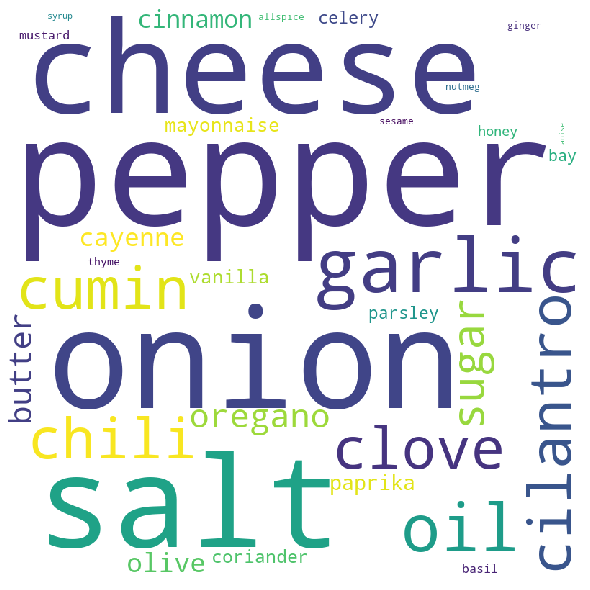

In [31]:
plt_wordcloud(data)

## 1.4 Extract cooking methods for each recipe

Beside the ingredients, cooking method also varies across country. When 'boiling eggs' or 'frying eggs', the ingredients used are the same, yet the look, the smell and the flavor of the dishes are distinct. In this section we extract cooking methods from column 'steps' from the dataframe.

In [32]:
method_list = ['bake', 'barbecue', 'blanch', 'blend', 'boil', 'braise', 'brine', 'broil', 'caramelize', 
               'combine','crock pot','crush','deglaze','devein','dice','distill','drain','emulsify','ferment',
               'freez','fry','grate','griddle','grill','knead','leaven','marinate','mash','melt','microwave',
               'parboil','pickle','poach','pour','pressure cook','puree','refrigerat','roast','saute','scald',
               'scramble','shred','simmer','skillet','slow cook','smoke','smooth','soak','sous-vide','steam',
               'stew','strain','tenderize','thicken','toast','toss','whip','whisk']

In [33]:
recipe_cooking = recipe_country.copy()

In [34]:
recipe_cooking['steps'] = recipe_cooking['steps'].apply(eval)

In [35]:
def identify_cooking(row):
    r_list = set([])
    for stc in row:
        s_list = re.findall(r"[\w']+", stc)
        for word in s_list:
            if word in method_list:
                r_list.add(word)
    return list(r_list)

In [36]:
recipe_cooking['method'] = recipe_cooking['steps'].apply(identify_cooking)

In [37]:
recipe_cooking.reset_index(drop = True, inplace = True)

In [38]:
recipe_cooking.drop(index = recipe_cooking[recipe_cooking['method'].apply(len) == 0].index, inplace = True)   

In [39]:
recipe_cooking.head()

,name,id,country,continent,minutes,contributor_id,submitted,n_steps,steps,description,ingredients,n_ingredients,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g),method
0,arriba baked winter squash mexican style,137739,United States of America,North America,55,47892,2005-09-16,11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0,[bake]
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0,[bake]
2,a bit different breakfast pizza,31490,United States of America,North America,30,26278,2002-06-17,9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0,"[pour, whisk, bake]"
3,amish tomato ketchup for canning,44061,United States of America,North America,190,41706,2002-10-25,5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0,"[pour, boil]"
4,apple a day milk shake,5289,United States of America,North America,0,1533,1999-12-06,4,"[combine ingredients in blender, cover and ble...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4,160.2,10.0,55.0,3.0,9.0,20.0,7.0,"[smooth, combine, blend]"


In [40]:
recipe_cooking_e = recipe_cooking.explode('method')

In [41]:
method_country = recipe_cooking_e.groupby(['country', 'method'])['id'].count().groupby('country').nlargest(10)
method_country = method_country.to_frame().droplevel(0).reset_index()  

#### American cooking method wordcloud

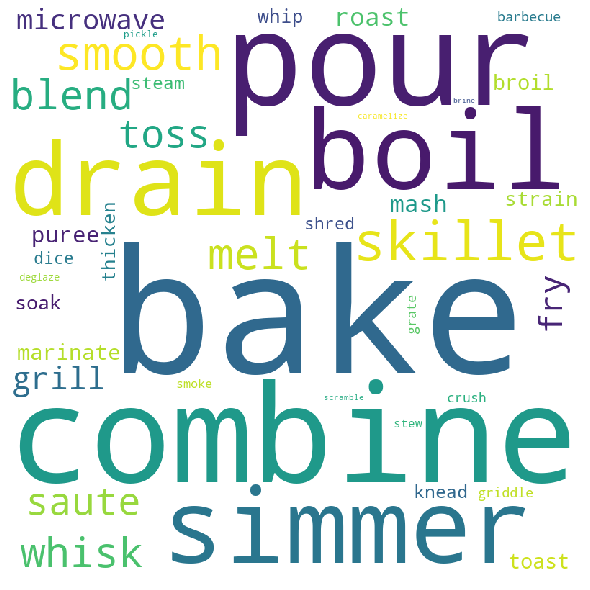

In [42]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'United States of America']['method'].values
plt_wordcloud(data)

#### Chinese cooking method wordcloud

In [43]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'China']['method'].values

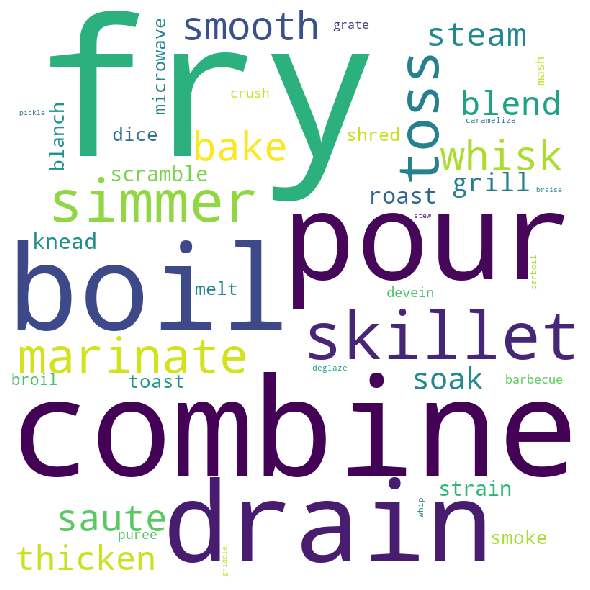

In [44]:
plt_wordcloud(data)

The top 10 most frequenly used cooking methods of American and Chinese are shown in a wordcloud below. The most popular way for Chinese is to fry, which coincides with our expectation. We can see that 'microwave' and 'bake' is not popular in China, because these methods are not traditional Chinese cooking methods. While for Americans, they are used to 'baking' things, and 'fry' will not be their top choice when cooking.

## 1.5 Extract main ingredients for each recipe

As mentioned in section 1.3, main ingredients are extracted. The categoreis (dairy, grain, vegetable, fruit, meat, seafood) are collected from supercook (https://www.supercook.com/#/recipes). 220 various ingredients are identified. 

In [45]:
dairy = ['egg', 'milk', 'cream', 'yogurt', 'frosting'] 
grain = ['rice', 'pasta', 'flour', 'bread', 'tortilla', 'pancake', 'pie', 'pizza']
vegetable = ['tomato', 'potato', 'carrot',
              'broccoli', 'corn', 'spinach', 'mushroom', 'beans', 'salad green', 'cucumber',
              'pickle', 'avocado', 'zucchini', 'cilantro', 'frozen vegetable', 'asparagus',
             'cabbage', 'cauliflower', 'kale', 'mixed vegetable', 'pumpkin', 'squash', 'scallion',
             'shallot', 'eggplant', 'beet', 'horseradish', 'leek', 'caper', 'brussels sprout',
             'artichoke', 'chia', 'radish', 'sauerkraut', 'artichoke', 'arugula', 'capsicum',
             'bok choy', 'parsnip', 'okra', 'yam', 'fennel', 'turnip', 'pea', 'seaweed', 'chard', 'collard',
             'pimiento', 'watercress', 'tomatillo', 'rocket' 'bamboo shoot', 'rutabaga', 'endive',
              'jicama',  'kohlrabi', 'palm', 'butternut', 'daikon', 'radicchio', 'porcini', 'jerusalem artichoke'
             'cress', 'chestnut', 'dulse', 'micro green', 'burdock', 'chayote']
fruit = ['lemon', 'apple', 'banana', 'lime', 'strawberry', 'orange', 'pineapple', 'blueberry', 
             'raisin', 'coconut', 'grape', 'peach', 'cranberry', 'mango', 'pear', 'blackberry', 'cherry',
        'watermelon', 'kiwi', 'grapefruit', 'mandarin', 'craisins', 'cantaloupe', 'plum', 'apricot',
         'clementine', 'prune', 'apple butter', 'pomegranate', 'nectarine', 'fig', 'tangerine', 'papaya',
         'rhubarb', 'sultana', 'plantain', 'currant', 'passion fruit', 'guava', 'persimmon', 'lychee',
         'lingonberry', 'tangelo', 'kumquat', 'boysenberry', 'star fruit', 'quince', 'honeydew', 'crabapple']
meat = ['chicken', 'beef', 'bacon', 'sausage', 'steak', 'ham', 'hot dog', 'pork', 'turkey', 'pepperoni',
       'salami', 'spam', 'venison','bologna', 'bratwurst', 'prosciutto', 'lamb', 'pancetta', 'duck', 'veal',
        'cornish hen', 'deer',  'pastrami', 'rabbit', 'elk', 'marrow bone', 'goose', 'quail', 'oxtail',
 'pheasant', 'moose', 'foie gra', 'boar', 'snail', 'pigeon', 'grouse', 'ostrich', 'soppressata', 'alligator']
seafood =  ['tuna', 'salmon', 'tilapia', 'fish fillets', 'cod', 'anchovy', 'sardine', 'whitefish',
            'halibut', 'trout', 'haddock', 'flounder', 'catfish', 'mahi mahi', 'mackerel', 'sole', 'sea bass',
            'red snapper', 'swordfish', 'pollock', 'herring', 'perch', 'grouper', 'caviar', 'monkfish', 
            'rockfish', 'pike', 'barramundi', 'eel', 'bluefish', 'carp', 'cuttlefish', 'pompano', 'arctic char',
            'john dory', 'marlin', 'amberjack', 'sturgeon', 'shrimp', 'crab', 'prawn', 'scallop', 'clam',
            'lobster', 'mussel', 'oyster', 'squid', 'calamari', 'crawfish', 'octopus', 'cockle', 'conch',
            'sea urchin']

In [46]:
unions = dairy + vegetable + fruit + meat + seafood + grain

In [47]:
recipe_country_ingreds = recipe_country_cp.explode('ingredients')

In [48]:
def identify_ingredients(row):
    s_list = re.findall(r"[\w']+", row)
    engine = inflect.engine()
    r_list = []
    for word in s_list:
        if re.search('|'.join(unions), word) is not None:
            if engine.singular_noun(word) is True:
                word = engine.singular_noun(word)
            if word in unions:
                r_list.append(word)
    return r_list

In [49]:
recipe_country_ingreds['ingredients'] = recipe_country_ingreds['ingredients'].apply(identify_ingredients)

In [50]:
recipe_main = recipe_country_ingreds[recipe_country_ingreds['ingredients'].apply(len) > 0]

In [51]:
recipe_main.head()

,name,id,country,continent,minutes,contributor_id,submitted,n_steps,steps,description,ingredients,n_ingredients,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
0,arriba baked winter squash mexican style,137739,United States of America,North America,55,47892,2005-09-16,11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,[squash],7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,[squash],7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
2,a bit different breakfast pizza,31490,United States of America,North America,30,26278,2002-06-17,9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[pizza],6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,a bit different breakfast pizza,31490,United States of America,North America,30,26278,2002-06-17,9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[sausage],6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,a bit different breakfast pizza,31490,United States of America,North America,30,26278,2002-06-17,9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[milk],6,173.4,18.0,0.0,17.0,22.0,35.0,1.0


In [52]:
recipe_main = recipe_main.explode('ingredients')

In [53]:
ingredient_country = recipe_main.groupby(['country', 'ingredients'])['id'].count().groupby('country').nlargest(50)
ingredient_country = ingredient_country.to_frame().droplevel(0).reset_index()  

#### American's popular ingredients for cooking

In [54]:
ingredient_country[ingredient_country['country'] == 'United States of America'][:10]

,country,ingredients,id
2815,United States of America,cream,41943
2816,United States of America,flour,41181
2817,United States of America,chicken,37614
2818,United States of America,milk,28923
2819,United States of America,lemon,20976
2820,United States of America,egg,20109
2821,United States of America,beans,17296
2822,United States of America,beef,16776
2823,United States of America,corn,16534
2824,United States of America,tomato,13510


In [55]:
data = recipe_main[recipe_main['country'] == 'United States of America']['ingredients'].values

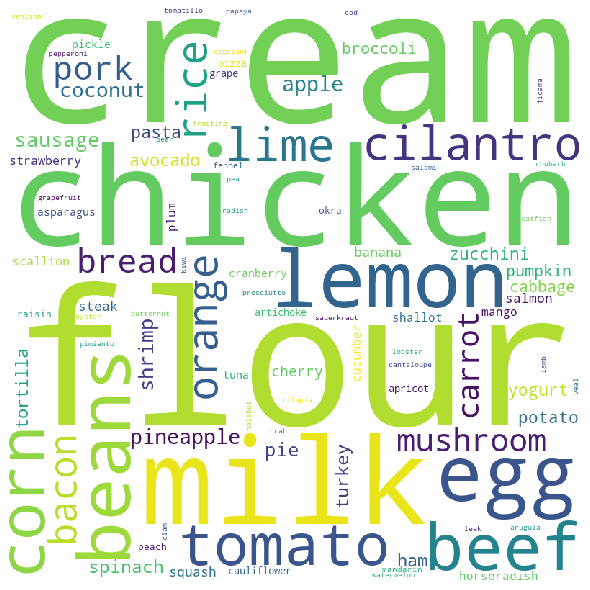

In [56]:
plt_wordcloud(data)

#### Chineses' popular ingredients for cooking

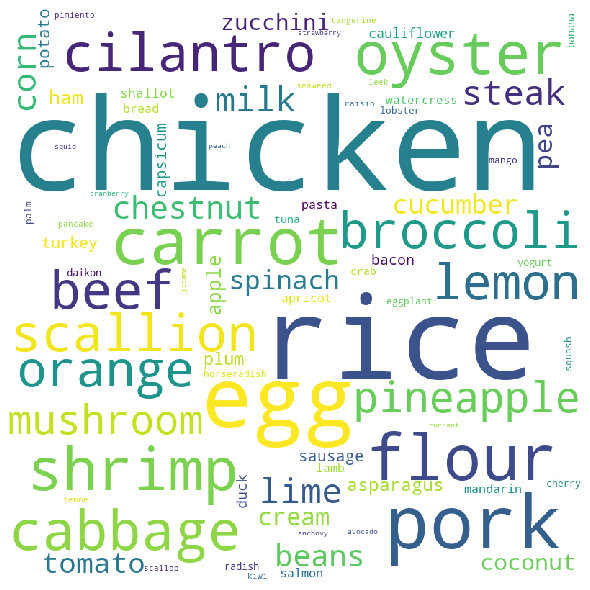

In [57]:
data = recipe_main[recipe_main['country'] == 'China']['ingredients'].values
plt_wordcloud(data)

The wordclouds shown above seem to make sense. Rice is popular in asian areas like China. Milk and beans are popular choices for meals in America. Yet in China these two are seldomly used for cooking. Pizza, as a total western food, does not appear in the top 50 frequently used ingredients for Chinese.

## 1.6 Drawing the choropleth map of the nutrition facts

Nutrition in the diet has a direct impact on people's health. We draw here a choropleth map based on the average nutrition facts of the dishes from different countries.

In [58]:
avg_nutrition = recipe_country.groupby("country").mean()

In [59]:
avg_nutrition = avg_nutrition[nutritions_list].reset_index()

In [60]:
avg_nutrition.head()

,country,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
0,Angola,362.830769,28.076923,58.461538,18.769231,32.692308,32.307692,10.846154
1,Argentina,533.674194,51.887097,34.104839,26.814516,43.782258,45.637097,10.887097
2,Australia,473.585870,36.557821,82.864675,20.169420,34.888928,47.525483,15.252724
3,Austria,607.671765,46.129412,121.288235,21.541176,34.335294,59.923529,22.076471
4,Belgium,523.245455,44.915152,52.412121,20.327273,44.109091,58.812121,13.054545


In [61]:
import geopandas
from matplotlib import cm

In [62]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [63]:
avg_nutrition = avg_nutrition[~avg_nutrition.country.isin(['Caribbean', 'Hawaii', 'Melanesia', 'Polynesia'])].reset_index(drop=True)

In [64]:
merged = world.set_index('name').join(avg_nutrition.set_index('country'))

In [66]:
def plot_nutrition(column):
    # plot as usual, grab the axes 'ax' returned by the plot
    colormap = "OrRd"   # add _r to reverse the colormap
    ax = merged.plot(color="grey", figsize=(12, 9))
    ax2 = merged.dropna().plot(ax=ax, column=column, cmap=colormap, figsize=[12,9])

    # map marginal/face deco
    ax2.set_title("Average " + column + " in recipes from different countries" + \
                  "\n (missing values are plotted in grey)")

    # colorbar will be created by ...
    fig = ax2.get_figure()
    # add colorbar axes to the figure
    # here, need trial-and-error to get [l,b,w,h] right
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
    cbax.set_title(column)

    sm = plt.cm.ScalarMappable(cmap=colormap, \
                    norm=plt.Normalize(vmin=min(merged[column].dropna()), vmax=max(merged[column].dropna())))
    # at this stage, 
    # 'cbax' is just a blank axes, with un needed labels on x and y axes

    # blank-out the array of the scalar mappable 'sm'
    sm._A = []
    # draw colorbar into 'cbax'
    fig.colorbar(sm, cax=cbax, format="%d")

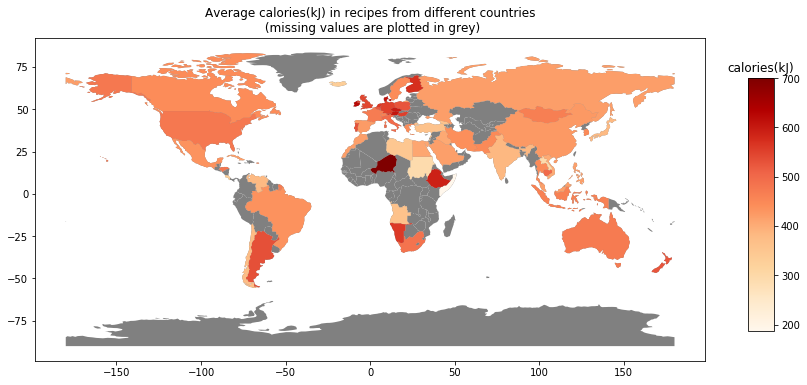

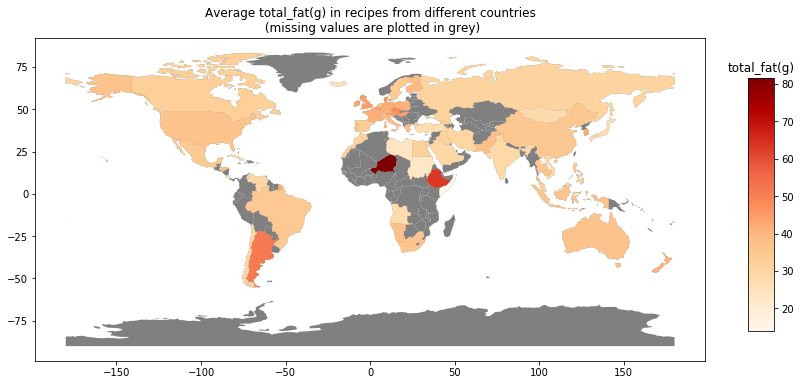

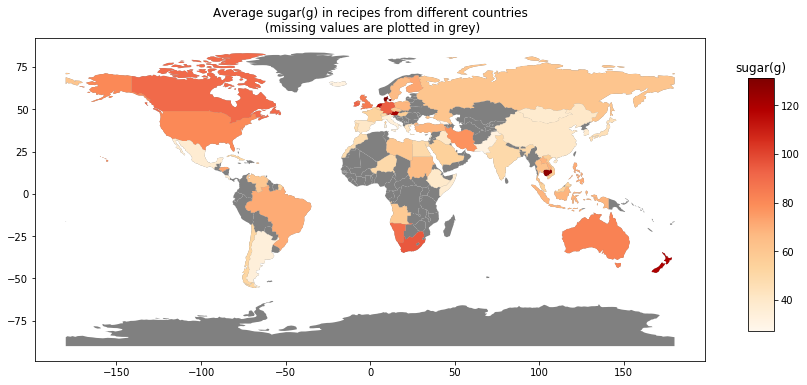

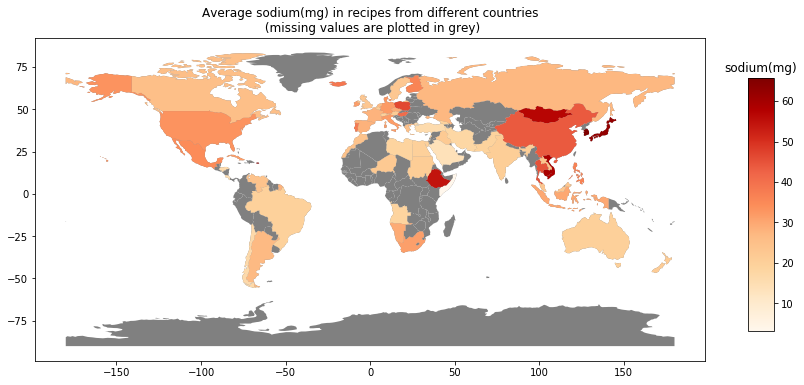

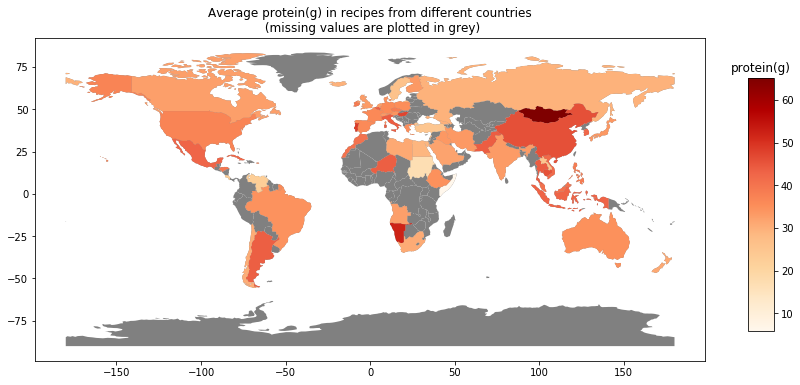

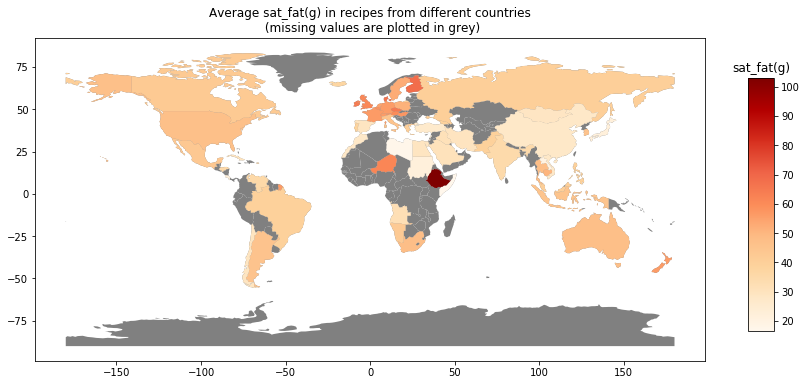

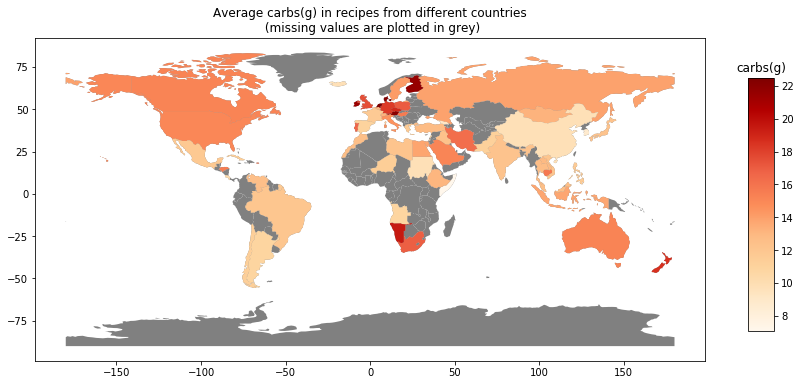

In [69]:
for column in nutritions_list:
    plot_nutrition(column)

Clearly, recipes originated from western countries tend to contain relatively high calories, carbs and saturated fat while those from eastern countries tend to contain high sodium and high proteins.

# 2. Incoporating WHO dataset

We read in some health statistics from WHO. Since the most recent available data related to diseases are those collected in 2016, for the sake of coherence, we use 2016 version of other statistics. The first one to read in is the life span.

In [104]:
health_data= pd.read_csv('data/RAW_lifespan.csv')
health_data = health_data[health_data['Indicator']=='Life expectancy at birth (years)']
health_data = health_data[health_data['Dim1'] == 'Both sexes']
health_data.drop(columns=['Indicator','Period','Dim1'],inplace=True)
health_data.rename(columns={'First Tooltip':'Life span'},inplace=True)
health_data.reset_index(drop=True, inplace=True)

Then we add some food-related common health indices which includes 'overweight', 'blood_pressure', 'blood_glucose', 'cholesterol' from the data download from WHO website. The data shows the percentage of total population in a country suffering from these common diseases and NCD death rate (non-communicable diseases, including Malignant neoplasms, Diabetes mellitus, Cardiovascular diseases, Chronic obstructive pulmonary disease) in different countries.

In [105]:
dataset_list = ['data_overweight.csv', 'data_blood_glucose.csv', 'data_blood_pressure.csv', 
                'data_cholesterol.csv', 'data_NCD_death.csv']
column_names = ['Overweight(%)', 'High Blood Glucose(%)', 'High Blood Pressure(%)', 'High Cholesterol(%)',
                'NCD death probability(%)']

In [106]:
for ind, dataset in enumerate(dataset_list):
    data_sub = pd.read_csv(os.path.join('data', dataset))
    data_sub.rename(columns={'First Tooltip':column_names[ind]}, inplace=True)
    health_data = health_data.merge(data_sub[['Location',column_names[ind]]])

In [107]:
cols = ['Overweight(%)','High Blood Glucose(%)','High Blood Pressure(%)','High Cholesterol(%)']
for c in cols:
    health_data[c]=health_data[c].str.split('[',expand=True)[0].astype('float')

We further add the death rate due to some specific disease types in a country. To calculate the incidence rate, we also import the population of different countries.

In [108]:
data_disease= pd.read_csv('data/data_disease_death.csv')
data_disease = data_disease[['Location','Dim2','First Tooltip']]

In [109]:
data_pop= pd.read_csv('data/data_population.csv')
data_pop = data_pop[data_pop['Time']==2016][['Location','PopTotal']]
health_data = pd.merge(health_data, data_pop)
health_data.rename(columns={'PopTotal': 'PopTotal(k)'}, inplace=True)

In [110]:
data_disease= pd.read_csv('data/data_disease_death.csv')
data_disease = data_disease[['Location','Dim2','First Tooltip']]
data_disease= pd.merge(data_disease,data_pop,on='Location')
data_disease['disease(%)']=data_disease['First Tooltip']/data_disease['PopTotal']/10

In [111]:
diseases = ['Malignant neoplasms','Diabetes mellitus','Cardiovascular diseases','Chronic obstructive pulmonary disease']
for d in diseases:
    data_sub=data_disease.loc[data_disease['Dim2']==d].copy()
    data_sub.rename(columns={'disease(%)':d+' death(%)'},inplace=True)
    health_data=pd.merge(health_data,data_sub[['Location',d+' death(%)']],on='Location')

The GNI per capita is the dollar value of a country's final income in a year, divided by its population. It should be reflecting the average before tax income of a country's citizens. In particular, a country's GNI per capita tends to be closely linked with other indicators of public health of a country. For example the life span in wealthy countries is usually higher than poorer ones. The data comes from world bank: https://data.worldbank.org/indicator/NY.GNP.PCAP.CD and according to the criterion given by world bank (see the table below), the countries are divided into different groups (High-income, Upper-middle-income, Lower-middle-income, Low-income). Again we use data in 2016.

| Thresholds    |  GNI/Capita (current US$)|
| ------------- |:-------------:|
| Low-income    | < 1006 |
| Lower-middle income     | 1,006 - 3,955     |
| Upper-middle income | 3,956 - 12,235      |
|High-income    | > 12,235|

In [112]:
data_gni=pd.read_csv('data/GNI_per_capita.csv')
data_gni=data_gni[['Country Name','2016']]
data_gni.rename(columns={'Country Name':'Location','2016':'GNP per capita($)'},inplace=True)

In [113]:
health_data = pd.merge(health_data,data_gni,on='Location')

In [114]:
health_data.dropna(inplace=True)
health_data.reset_index(drop=True, inplace=True)

In [115]:
health_data['income group'] = np.nan

In [138]:
health_data['income group'].iloc[health_data[health_data['GNP per capita($)'] < 1006].index] = 'low'
health_data['income group'].iloc[health_data[(health_data['GNP per capita($)'] >= 1006)
                                              & (health_data['GNP per capita($)'] < 3955)].index] = 'lower-middle'
health_data['income group'].iloc[health_data[(health_data['GNP per capita($)'] >= 3956)
                                              & (health_data['GNP per capita($)'] < 12235)].index] = 'uppter-middle'
health_data['income group'].iloc[health_data[health_data['GNP per capita($)'] > 12235].index] = 'high'

# 3. Relationship between eating habits and health

Recipes reflect the eating habits of a country. In the following, based on the data collected from recipes, we study the relation between nutrition in food and health indices as well as relation between ingredients + cooking methods with health indices to identify good eating and cooking practices that are beneficial to one's health.

## 3.1 Nutrition in food v.s. health indices

In essence, the significance of eating is to provide nutrition to our body so that it can go on functioning. Therefore, the nutrition in food should have a direct impact on health.

## 3.2 Ingredients and cooking methods v.s. health indices